In [1]:
import logging
import math
import scipy as sp
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torchmetrics.regression import MeanAbsolutePercentageError
import pennylane as qml

import matplotlib.pyplot as plt
plt.style.use('./pptnqfe.mplstyle')

from qulearn.hat_basis import HatBasis
from qulearn.trainer import SupervisedTrainer
from qulearn.qlayer import (HatBasisQFE,
                            TwoQubitRotCXMPSLayer,
                            EmbedU,
                            ParallelIQPEncoding,
                            AltRotCXLayer,
                            MeasurementLayer,
                            HamiltonianLayer,
                            MeasurementType)

2024-02-07 13:42:57.403944: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-07 13:42:58.563027: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Section 5.2

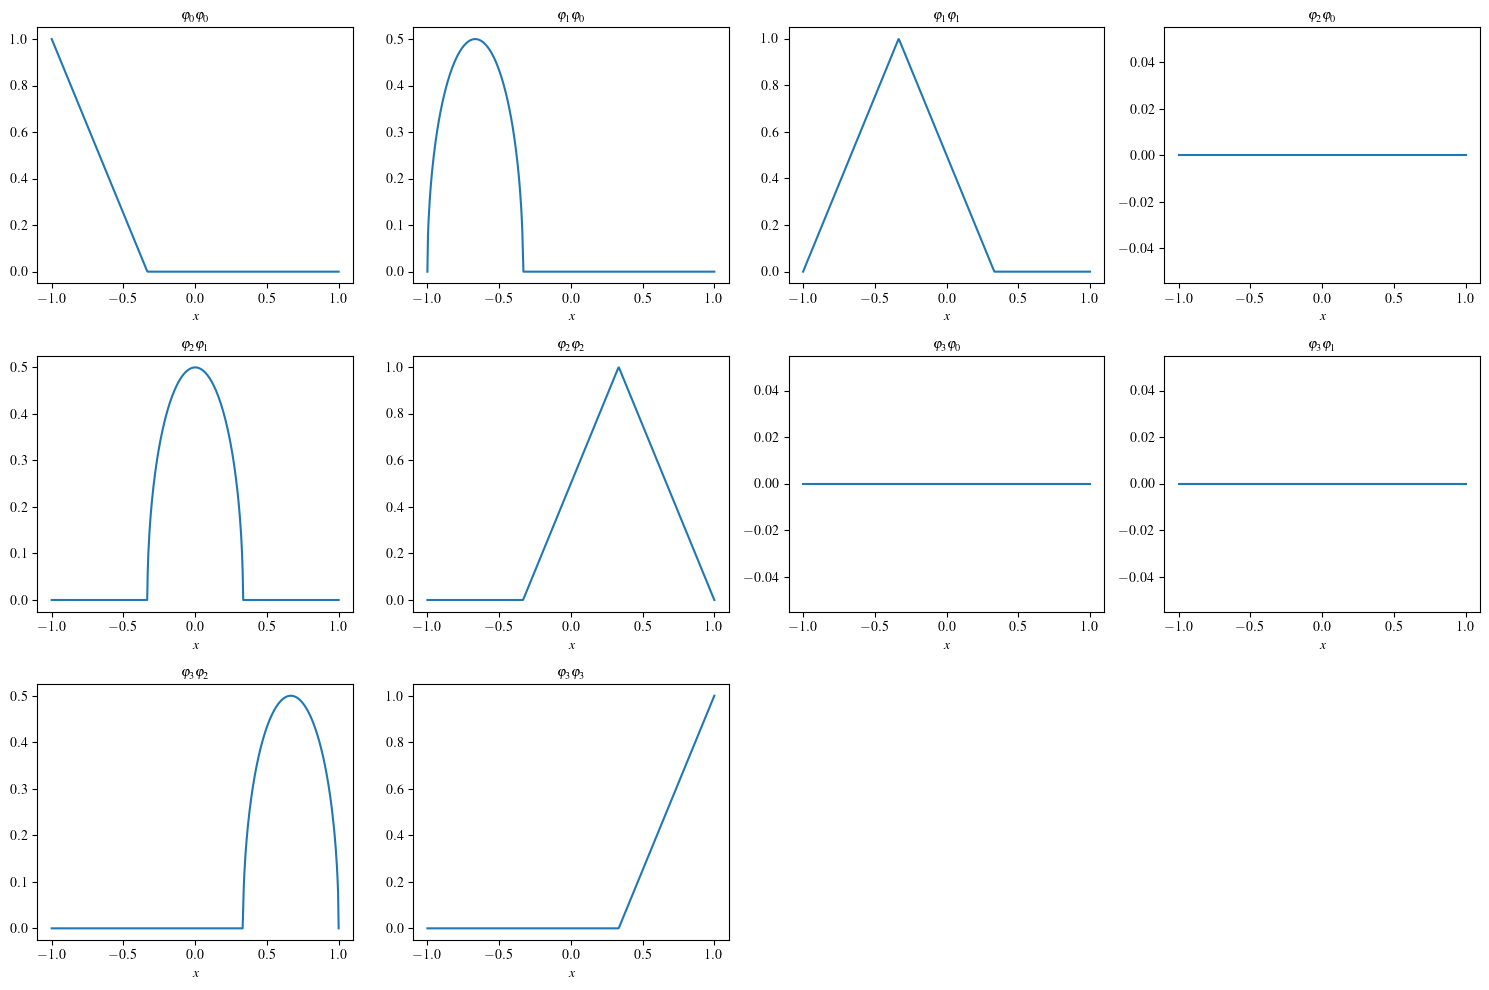

In [2]:
num_qubits = 2
num_nodes = 2**num_qubits
a = -1.0
b = 1.0
hat_basis = HatBasis(a=a, b=b, num_nodes=num_nodes)

num_pnts = 500
xvals = torch.linspace(-1.0, 1.0, num_pnts)
basis_vectors = hat_basis.eval_basis_vector(xvals)
basis_vectors = torch.sqrt(basis_vectors)

num_subplots = num_nodes * (num_nodes + 1) // 2
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
axs_flat = axs.flatten()

subplot_idx = 0
for i in range(num_nodes):
    for j in range(i + 1):
        axs_flat[subplot_idx].plot(xvals, basis_vectors[:, i] * basis_vectors[:, j])
        axs_flat[subplot_idx].set_title(f'$\\varphi_{i}\\varphi_{j}$')
        axs_flat[subplot_idx].set_xlabel('$x$')
        subplot_idx += 1

for idx in range(subplot_idx, len(axs_flat)):
    fig.delaxes(axs_flat[idx])

plt.tight_layout()
plt.savefig('./figures/basis_funcs.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [3]:
num_qubits = 5
num_nodes = 2**num_qubits
a = -1.0
b = 1.0
hat_basis = HatBasis(a=a, b=b, num_nodes=num_nodes)

embed = HatBasisQFE(wires=num_qubits, basis=hat_basis, sqrt=True, normalize=False)
obs = qml.PauliZ(0)
model = MeasurementLayer(embed, observables=obs, measurement_type=MeasurementType.Expectation)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([0.0])
print(drawer(x))

0: ──────────────────────╭U(M2)─┤  <Z>
1: ───────────────╭U(M1)─╰U(M2)─┤     
2: ────────╭U(M1)─╰U(M1)────────┤     
3: ─╭U(M0)─╰U(M1)───────────────┤     
4: ─╰U(M0)──────────────────────┤     


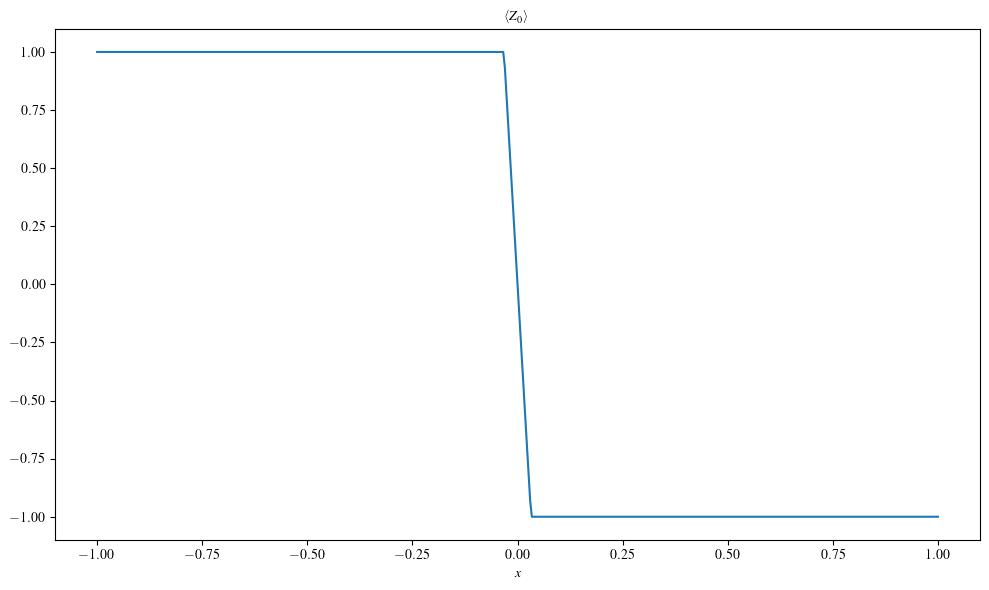

In [4]:
num_pnts = 500
xvals = torch.linspace(-1.0, 1.0, num_pnts).unsqueeze(-1)
yvals = model(xvals)

plt.figure(figsize=(10, 6))
plt.plot(xvals, yvals)
plt.xlabel('$x$')
plt.title("$\langle Z_0\\rangle$")
plt.tight_layout()
plt.savefig('./figures/z0.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [5]:
obs = qml.PauliZ(num_qubits-1)
model = MeasurementLayer(embed, observables=obs, measurement_type=MeasurementType.Expectation)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([0.0])
print(drawer(x))

0: ──────────────────────╭U(M2)─┤     
1: ───────────────╭U(M1)─╰U(M2)─┤     
2: ────────╭U(M1)─╰U(M1)────────┤     
3: ─╭U(M0)─╰U(M1)───────────────┤     
4: ─╰U(M0)──────────────────────┤  <Z>


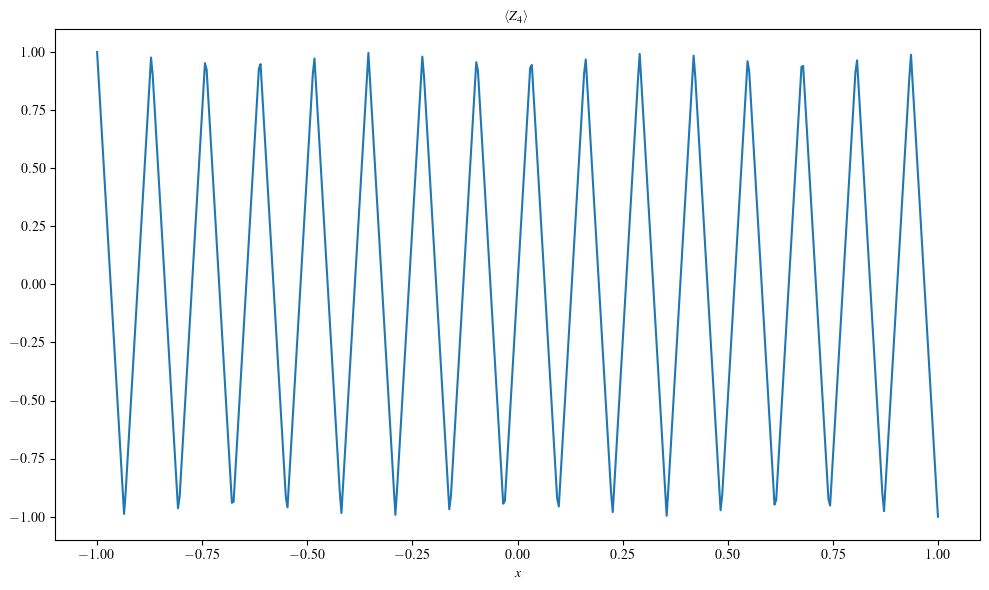

In [6]:
yvals = model(xvals)
plt.figure(figsize=(10, 6))
plt.plot(xvals, yvals)
plt.xlabel('$x$')
plt.title("$\langle Z_4\\rangle$")
plt.tight_layout()
plt.savefig('./figures/zn.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [7]:
obs = qml.PauliX(4)
model = MeasurementLayer(embed, observables=obs, measurement_type=MeasurementType.Expectation)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([0.0])
print(drawer(x))

0: ──────────────────────╭U(M2)─┤     
1: ───────────────╭U(M1)─╰U(M2)─┤     
2: ────────╭U(M1)─╰U(M1)────────┤     
3: ─╭U(M0)─╰U(M1)───────────────┤     
4: ─╰U(M0)──────────────────────┤  <X>


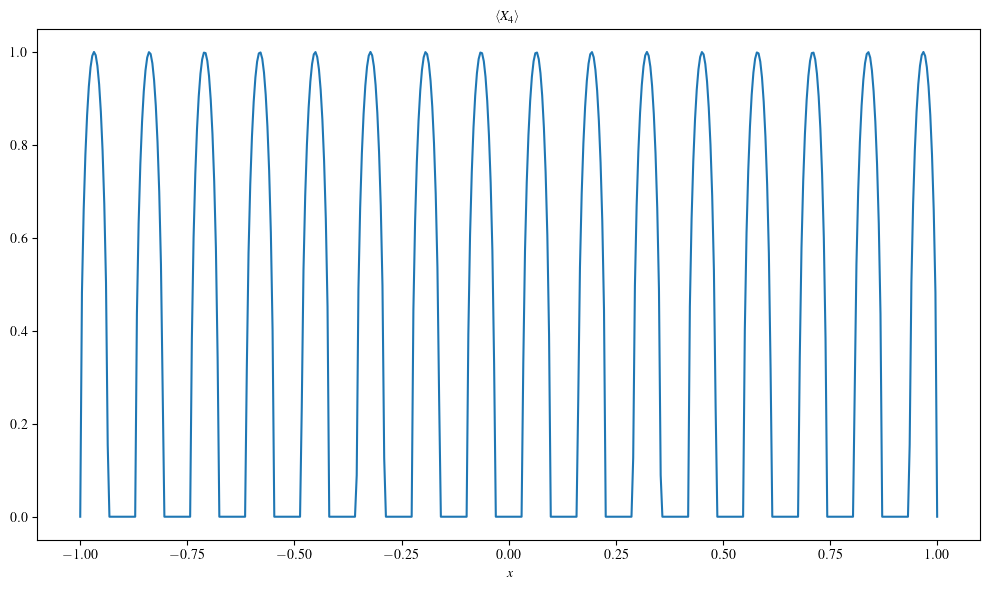

In [8]:
yvals = model(xvals)
plt.figure(figsize=(10, 6))
plt.plot(xvals, yvals)
plt.xlabel('$x$')
plt.title("$\langle X_4\\rangle$")
plt.tight_layout()
plt.savefig('./figures/xn.pdf', format='pdf', bbox_inches='tight')
plt.show()

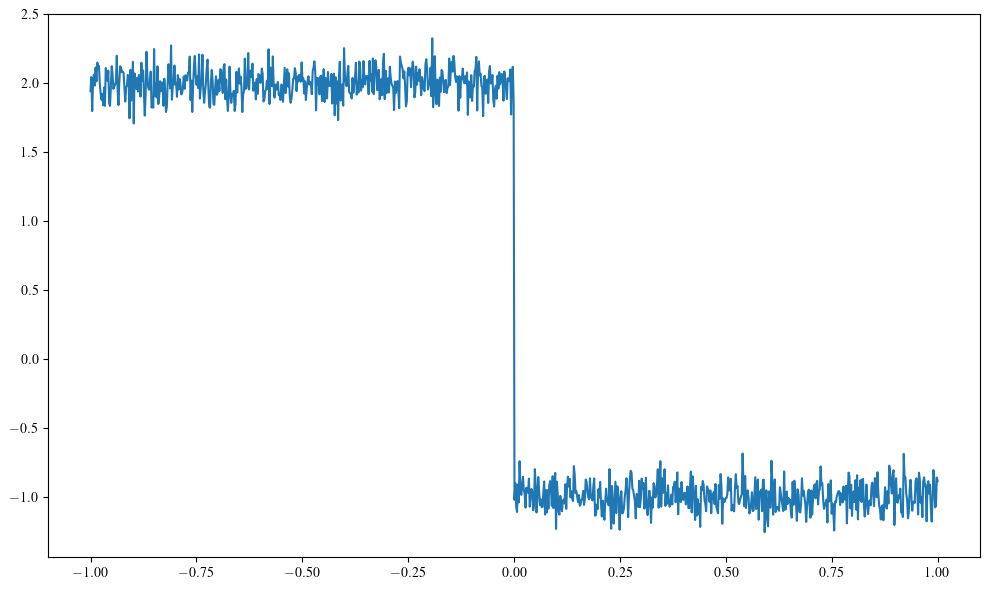

In [9]:
def step_function(
    X, threshold1=-1.0, threshold2=0.0, low_value=0.0, mid_value=2, high_value=-1.0
):
    condition1 = X < threshold1
    condition2 = (X >= threshold1) & (X < threshold2)
    condition3 = X >= threshold2

    values = torch.zeros_like(X)
    values[condition1] = low_value
    values[condition2] = mid_value
    values[condition3] = high_value

    return values

def add_gaussian_noise(tensor, mean=0.0, std=0.01):
    return tensor + torch.randn(tensor.size()) * std + mean

X = torch.linspace(-1, 1, 1000).reshape(-1, 1)
func = step_function
sigma = 0.1
Y = add_gaussian_noise(func(X), std=sigma)
plt.figure(figsize=(10, 6))
plt.plot(X, Y)
plt.tight_layout()
plt.savefig('./figures/stepfunc.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [10]:
obs = [qml.Identity(0), qml.PauliZ(0)]
model = HamiltonianLayer(embed, observables=obs)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([0.0])
print(drawer(x))
nump = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", nump)

0: ──────────────────────╭U(M2)─┤  <𝓗(-0.67,0.20)>
1: ───────────────╭U(M1)─╰U(M2)─┤                 
2: ────────╭U(M1)─╰U(M1)────────┤                 
3: ─╭U(M0)─╰U(M1)───────────────┤                 
4: ─╰U(M0)──────────────────────┤                 
Number of parameters:  2


In [11]:
N_train = 50
N_valid = 10
batch_size = 10
X_train = torch.linspace(-1, 1, N_train, dtype=torch.float64).reshape(-1, 1)
Y_train = add_gaussian_noise(func(X_train), std=sigma)
X_valid = torch.linspace(-1, 1, N_valid, dtype=torch.float64).reshape(-1, 1)
Y_valid = func(X_valid)
data_train = TensorDataset(X_train, Y_train)
data_valid = TensorDataset(X_valid, Y_valid)
loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
loader_valid = DataLoader(data_valid, batch_size=batch_size, shuffle=True)

lr = 0.1
optimizer = Adam(model.parameters(), lr=lr, amsgrad=True)
loss_fn = torch.nn.MSELoss()
metric = MeanAbsolutePercentageError()

logger = logging.getLogger("train_function")
logger.setLevel(level=logging.INFO)
num_epochs = 100
trainer = SupervisedTrainer(
    optimizer=optimizer,
    loss_fn=loss_fn,
    metrics={"MARE": metric},
    num_epochs=num_epochs,
    logger=logger,
)

In [12]:
trainer.train(model, train_data=loader_train, valid_data=loader_valid)

INFO:train_function:Train - Epoch: 1, Loss: 1.159454, Metrics: MARE: 0.437151
INFO:train_function:Validate - Epoch: 1, Loss: 1.122459, Metrics: MARE: 0.438576
INFO:train_function:Train - Epoch: 2, Loss: 0.236192, Metrics: MARE: 0.219358
INFO:train_function:Validate - Epoch: 2, Loss: 0.204035, Metrics: MARE: 0.213437
INFO:train_function:Train - Epoch: 3, Loss: 0.025748, Metrics: MARE: 0.075737
INFO:train_function:Validate - Epoch: 3, Loss: 0.003838, Metrics: MARE: 0.048877
INFO:train_function:Train - Epoch: 4, Loss: 0.114271, Metrics: MARE: 0.160829
INFO:train_function:Validate - Epoch: 4, Loss: 0.101645, Metrics: MARE: 0.124302
INFO:train_function:Train - Epoch: 5, Loss: 0.163305, Metrics: MARE: 0.190078
INFO:train_function:Validate - Epoch: 5, Loss: 0.153696, Metrics: MARE: 0.149203
INFO:train_function:Train - Epoch: 6, Loss: 0.098967, Metrics: MARE: 0.164166
INFO:train_function:Validate - Epoch: 6, Loss: 0.085816, Metrics: MARE: 0.128890
INFO:train_function:Train - Epoch: 7, Loss: 0.

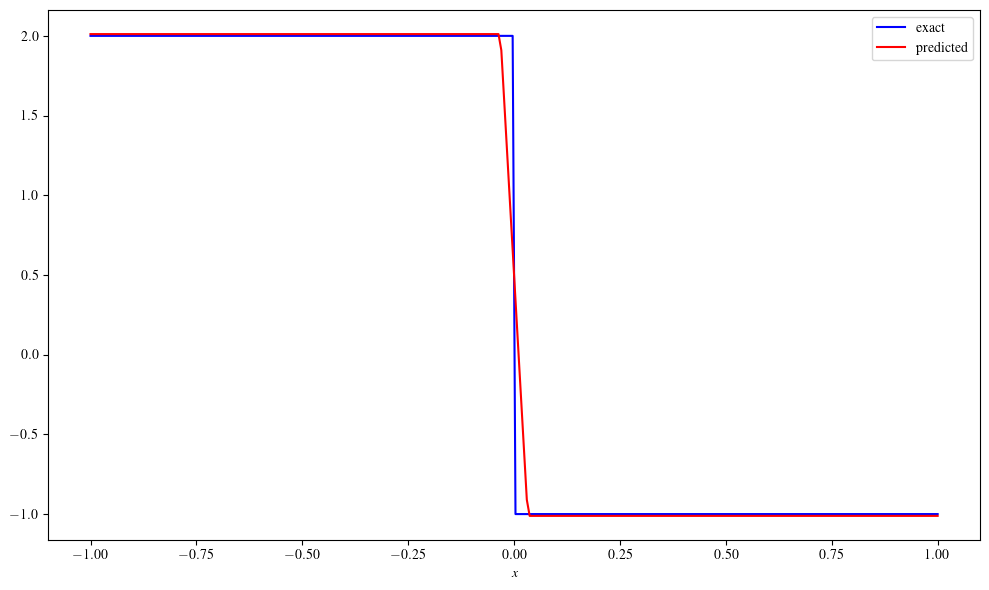

In [13]:
X = torch.linspace(-1, 1, 300, dtype=torch.float64).reshape(-1, 1)
Y_exact = func(X)
model.eval()
with torch.no_grad():
    Y_model = model(X)
plt.figure(figsize=(10, 6))
plt.plot(X, Y_exact, label="exact", color="blue")
plt.plot(X, Y_model, label="predicted", color="red")
plt.xlabel("$x$")
plt.legend()
plt.tight_layout()
plt.savefig('./figures/stepfunc_train_pptnqfe.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [14]:
num_features = 1
base = 3.0
omega = 1.0
embed = ParallelIQPEncoding(wires=num_qubits,
                            num_features=num_features,
                            n_repeat=1,
                            base=base,
                            omega=omega)
n_layers = 3
var = AltRotCXLayer(wires=num_qubits, n_layers=n_layers)

obs = [qml.Identity(0), qml.PauliZ(0)]
model = HamiltonianLayer(embed, var, observables=obs)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([1.0])
print(drawer(x))
nump = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", nump)

0: ──H──RZ(1.00)───Rot(2.17,0.75,4.81)─╭●──Rot(4.07,3.04,4.94)─────────────────────────╭●
1: ──H──RZ(3.00)───Rot(1.67,4.06,5.76)─╰X──Rot(6.25,3.79,5.94)─╭●──Rot(5.70,5.34,1.27)─╰X
2: ──H──RZ(9.00)───Rot(1.12,0.75,0.69)─╭●──Rot(4.47,3.87,4.47)─╰X──Rot(3.76,5.03,1.82)─╭●
3: ──H──RZ(27.00)──Rot(1.77,1.42,6.16)─╰X──Rot(1.32,0.65,4.23)─╭●──Rot(3.13,0.08,1.35)─╰X
4: ──H──RZ(81.00)──Rot(4.80,3.84,0.91)─────────────────────────╰X──Rot(0.73,1.07,2.28)───

───Rot(1.94,2.78,5.07)─────────────────────────╭●──Rot(4.45,4.97,5.40)─────────────────────────┤
───Rot(2.94,5.00,0.46)─╭●──Rot(1.25,4.40,1.52)─╰X──Rot(1.04,5.24,1.23)─╭●──Rot(5.20,4.59,4.70)─┤
───Rot(2.41,1.52,4.21)─╰X──Rot(4.52,1.89,5.62)─╭●──Rot(0.38,0.16,5.64)─╰X──Rot(2.61,5.06,5.06)─┤
───Rot(0.95,1.15,0.69)─╭●──Rot(5.17,1.82,3.98)─╰X──Rot(1.76,1.17,2.59)─╭●──Rot(4.78,2.72,2.40)─┤
───────────────────────╰X──Rot(2.69,4.71,4.78)─────────────────────────╰X──Rot(2.71,6.24,4.89)─┤

   <𝓗(-1.04,0.47)>
                  
                  
      

In [15]:
optimizer = Adam(model.parameters(), lr=lr, amsgrad=True)
trainer = SupervisedTrainer(
    optimizer=optimizer,
    loss_fn=loss_fn,
    metrics={"MARE": metric},
    num_epochs=num_epochs,
    logger=logger,
)

In [16]:
trainer.train(model, train_data=loader_train, valid_data=loader_valid)

INFO:train_function:Train - Epoch: 1, Loss: 3.239325, Metrics: MARE: 0.953856
INFO:train_function:Validate - Epoch: 1, Loss: 3.221591, Metrics: MARE: 0.950244
INFO:train_function:Train - Epoch: 2, Loss: 2.269692, Metrics: MARE: 1.097372
INFO:train_function:Validate - Epoch: 2, Loss: 2.290781, Metrics: MARE: 1.093750
INFO:train_function:Train - Epoch: 3, Loss: 1.459398, Metrics: MARE: 0.930532
INFO:train_function:Validate - Epoch: 3, Loss: 1.408801, Metrics: MARE: 0.896567
INFO:train_function:Train - Epoch: 4, Loss: 0.515858, Metrics: MARE: 0.435660
INFO:train_function:Validate - Epoch: 4, Loss: 0.517124, Metrics: MARE: 0.444067
INFO:train_function:Train - Epoch: 5, Loss: 0.329880, Metrics: MARE: 0.330404
INFO:train_function:Validate - Epoch: 5, Loss: 0.354076, Metrics: MARE: 0.339384
INFO:train_function:Train - Epoch: 6, Loss: 0.253550, Metrics: MARE: 0.301957
INFO:train_function:Validate - Epoch: 6, Loss: 0.286048, Metrics: MARE: 0.317679
INFO:train_function:Train - Epoch: 7, Loss: 0.

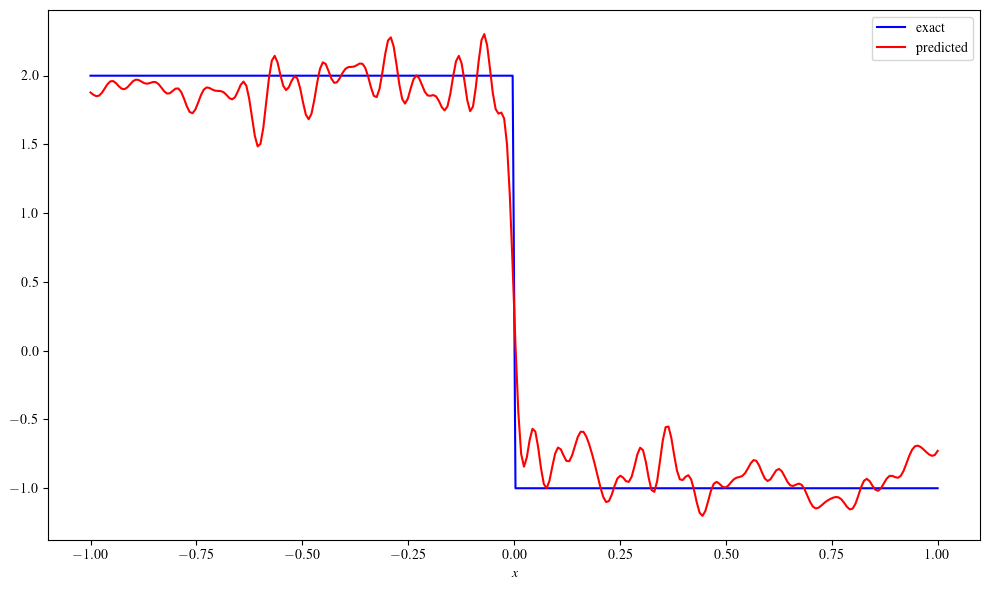

In [17]:
X = torch.linspace(-1, 1, 300, dtype=torch.float64).reshape(-1, 1)
Y_exact = func(X)
model.eval()
with torch.no_grad():
    Y_model = model(X)
plt.figure(figsize=(10, 6))
plt.plot(X, Y_exact, label="exact", color="blue")
plt.plot(X, Y_model, label="predicted", color="red")
plt.xlabel("$x$")
plt.legend()
plt.tight_layout()
plt.savefig('./figures/stepfunc_train_iqpe.pdf', format='pdf', bbox_inches='tight')
plt.show()

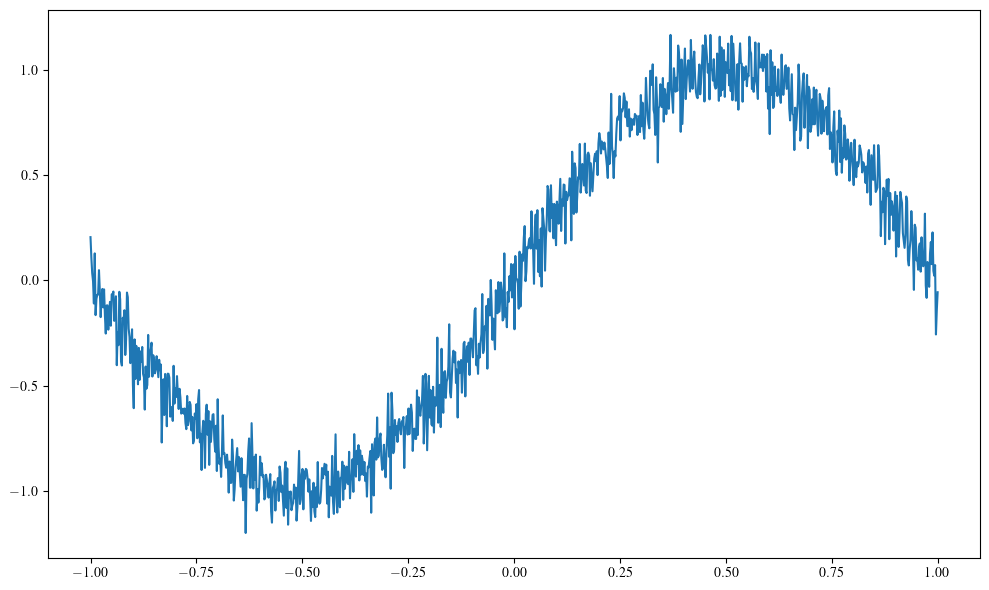

In [18]:
def trigonometric(X, a=1, b=math.pi, c=0.):
    return a * torch.sin(b * X + c)

X = torch.linspace(-1, 1, 1000).reshape(-1, 1)
func = trigonometric
sigma = 0.1
Y = add_gaussian_noise(func(X), std=sigma)
plt.figure(figsize=(10, 6))
plt.plot(X, Y)
plt.tight_layout()
plt.savefig('./figures/sin.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [19]:
embed = HatBasisQFE(wires=num_qubits, basis=hat_basis, sqrt=True, normalize=False)
num_mps_layers = 1
num_block_layers = 3
reverse = True
var = TwoQubitRotCXMPSLayer(num_qubits, 
                            n_layers_mps=num_mps_layers,
                            n_layers_block=num_block_layers,
                            reverse=reverse)

obs = [qml.Identity(0)] + [qml.PauliZ(j) for j in range(num_qubits)]
model = HamiltonianLayer(embed, var, observables=obs)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([0.0])
print(drawer(x))
nump = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", nump)

0: ──────────────────────────────────────────────────╭U(M2)────────────────Rot(0.41,4.68,6.10)───
1: ─────────────────────────────╭U(M1)───────────────╰U(M2)────────────────Rot(0.78,0.06,2.66)───
2: ────────╭U(M1)───────────────╰U(M1)────────────────Rot(3.66,1.81,5.77)────────────────────────
3: ─╭U(M0)─╰U(M1)────────────────Rot(5.91,3.12,4.77)─╭●────────────────────Rot(4.37,1.14,1.25)─╭●
4: ─╰U(M0)──Rot(4.88,1.10,2.35)──────────────────────╰X────────────────────Rot(4.96,5.46,4.92)─╰X

─────────────────────────────────────────────────────────────────────────────────────────────────
─────────────────────────────────────────────────────────────────────────────────────────────────
───────────────────────────────────────────────╭●──Rot(5.10,5.39,2.16)─╭●──Rot(2.30,0.09,1.98)─╭●
───Rot(2.22,3.34,3.81)─╭●──Rot(1.46,4.64,3.61)─╰X──Rot(1.58,0.96,3.22)─╰X──Rot(3.52,0.78,5.39)─╰X
───Rot(4.79,6.20,3.06)─╰X──Rot(5.35,0.34,3.88)───────────────────────────────────────────────────

──────────────────

In [20]:
N_train = 50
N_valid = 10
batch_size = 10
X_train = torch.linspace(-1, 1, N_train, dtype=torch.float64).reshape(-1, 1)
Y_train = add_gaussian_noise(func(X_train), std=sigma)
X_valid = torch.linspace(-1, 1, N_valid, dtype=torch.float64).reshape(-1, 1)
Y_valid = func(X_valid)
data_train = TensorDataset(X_train, Y_train)
data_valid = TensorDataset(X_valid, Y_valid)
loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
loader_valid = DataLoader(data_valid, batch_size=batch_size, shuffle=True)

optimizer = Adam(model.parameters(), lr=lr, amsgrad=True)
num_epochs = 100
trainer = SupervisedTrainer(
    optimizer=optimizer,
    loss_fn=loss_fn,
    metrics={"MARE": metric},
    num_epochs=num_epochs,
    logger=logger,
)

In [21]:
trainer.train(model, train_data=loader_train, valid_data=loader_valid)

INFO:train_function:Train - Epoch: 1, Loss: 0.458316, Metrics: MARE: 0.987651
INFO:train_function:Validate - Epoch: 1, Loss: 0.354003, Metrics: MARE: 26339.896484
INFO:train_function:Train - Epoch: 2, Loss: 0.216921, Metrics: MARE: 1.093717
INFO:train_function:Validate - Epoch: 2, Loss: 0.218289, Metrics: MARE: 59056.398438
INFO:train_function:Train - Epoch: 3, Loss: 0.108976, Metrics: MARE: 1.580480
INFO:train_function:Validate - Epoch: 3, Loss: 0.113747, Metrics: MARE: 86673.484375
INFO:train_function:Train - Epoch: 4, Loss: 0.127207, Metrics: MARE: 1.897277
INFO:train_function:Validate - Epoch: 4, Loss: 0.133540, Metrics: MARE: 100835.203125
INFO:train_function:Train - Epoch: 5, Loss: 0.093046, Metrics: MARE: 1.527765
INFO:train_function:Validate - Epoch: 5, Loss: 0.090951, Metrics: MARE: 79252.539062
INFO:train_function:Train - Epoch: 6, Loss: 0.063717, Metrics: MARE: 0.953491
INFO:train_function:Validate - Epoch: 6, Loss: 0.061791, Metrics: MARE: 53113.882812
INFO:train_function:T

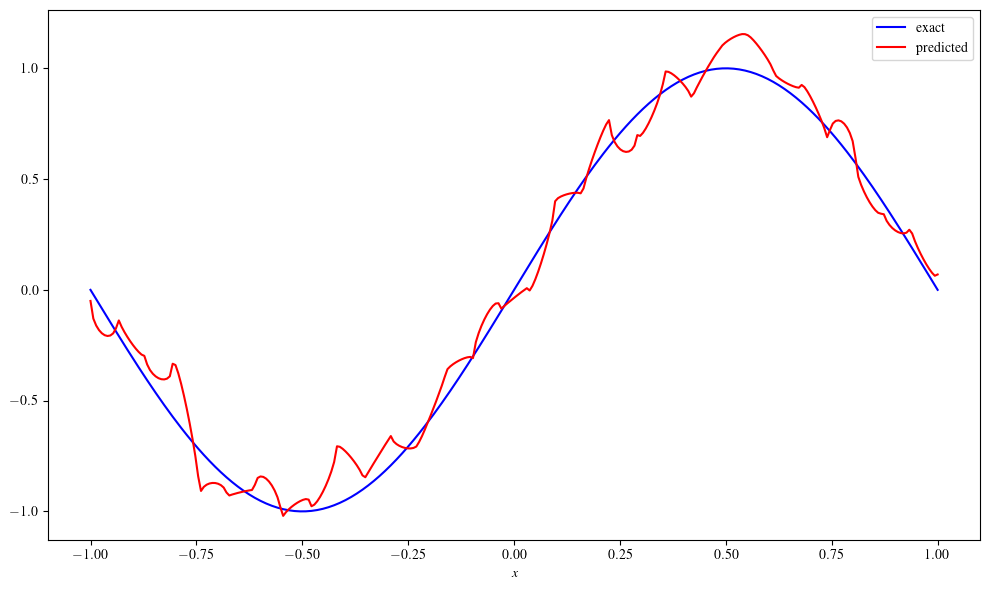

In [22]:
X = torch.linspace(-1, 1, 300, dtype=torch.float64).reshape(-1, 1)
Y_exact = func(X)
model.eval()
with torch.no_grad():
    Y_model = model(X)
plt.figure(figsize=(10, 6))
plt.plot(X, Y_exact, label="exact", color="blue")
plt.plot(X, Y_model, label="predicted", color="red")
plt.xlabel("$x$")
plt.legend()
plt.tight_layout()
plt.savefig('./figures/sin_train_pptnqfe.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [23]:
num_features = 1
base = 3.0
omega = 1.0
embed = ParallelIQPEncoding(wires=num_qubits,
                            num_features=num_features,
                            n_repeat=1,
                            base=base,
                            omega=omega)
n_layers = 3
var = AltRotCXLayer(wires=num_qubits, n_layers=n_layers)

obs = [qml.Identity(0)] + [qml.PauliZ(j) for j in range(num_qubits)]
model = HamiltonianLayer(embed, var, observables=obs)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([1.0])
print(drawer(x))
nump = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", nump)

0: ──H──RZ(1.00)───Rot(5.99,2.97,3.91)─╭●──Rot(2.30,4.56,5.94)─────────────────────────╭●
1: ──H──RZ(3.00)───Rot(2.46,2.92,1.26)─╰X──Rot(0.25,1.15,2.64)─╭●──Rot(1.42,3.37,5.41)─╰X
2: ──H──RZ(9.00)───Rot(6.16,3.61,4.80)─╭●──Rot(2.14,3.02,1.22)─╰X──Rot(3.74,0.00,5.99)─╭●
3: ──H──RZ(27.00)──Rot(5.75,3.65,1.73)─╰X──Rot(4.79,0.43,3.63)─╭●──Rot(6.25,4.46,2.08)─╰X
4: ──H──RZ(81.00)──Rot(4.16,1.12,0.59)─────────────────────────╰X──Rot(4.07,1.65,3.30)───

───Rot(6.04,0.36,2.83)─────────────────────────╭●──Rot(2.11,1.90,4.24)─────────────────────────┤ ╭<𝓗>
───Rot(0.38,3.02,0.52)─╭●──Rot(0.37,1.59,3.68)─╰X──Rot(2.88,1.20,4.98)─╭●──Rot(2.68,3.68,0.78)─┤ ├<𝓗>
───Rot(6.11,3.33,4.41)─╰X──Rot(0.17,0.04,2.97)─╭●──Rot(4.83,4.61,3.96)─╰X──Rot(1.78,3.48,4.10)─┤ ├<𝓗>
───Rot(3.38,4.95,1.03)─╭●──Rot(5.90,3.34,5.95)─╰X──Rot(0.46,2.16,3.99)─╭●──Rot(2.42,2.51,1.03)─┤ ├<𝓗>
───────────────────────╰X──Rot(1.96,5.04,2.13)─────────────────────────╰X──Rot(6.27,0.49,4.90)─┤ ╰<𝓗>
Number of parameters:  93


In [24]:
optimizer = Adam(model.parameters(), lr=lr, amsgrad=True)
trainer = SupervisedTrainer(
    optimizer=optimizer,
    loss_fn=loss_fn,
    metrics={"MARE": metric},
    num_epochs=num_epochs,
    logger=logger,
)

In [25]:
trainer.train(model, train_data=loader_train, valid_data=loader_valid)

INFO:train_function:Train - Epoch: 1, Loss: 0.258553, Metrics: MARE: 1.477711
INFO:train_function:Validate - Epoch: 1, Loss: 0.327977, Metrics: MARE: 133255.031250
INFO:train_function:Train - Epoch: 2, Loss: 0.220607, Metrics: MARE: 1.820613
INFO:train_function:Validate - Epoch: 2, Loss: 0.384726, Metrics: MARE: 141990.125000
INFO:train_function:Train - Epoch: 3, Loss: 0.134780, Metrics: MARE: 1.157372
INFO:train_function:Validate - Epoch: 3, Loss: 0.077752, Metrics: MARE: 79601.906250
INFO:train_function:Train - Epoch: 4, Loss: 0.113192, Metrics: MARE: 1.079021
INFO:train_function:Validate - Epoch: 4, Loss: 0.113867, Metrics: MARE: 54489.906250
INFO:train_function:Train - Epoch: 5, Loss: 0.061217, Metrics: MARE: 0.756040
INFO:train_function:Validate - Epoch: 5, Loss: 0.066728, Metrics: MARE: 52265.804688
INFO:train_function:Train - Epoch: 6, Loss: 0.051025, Metrics: MARE: 0.720498
INFO:train_function:Validate - Epoch: 6, Loss: 0.061822, Metrics: MARE: 51945.753906
INFO:train_function:

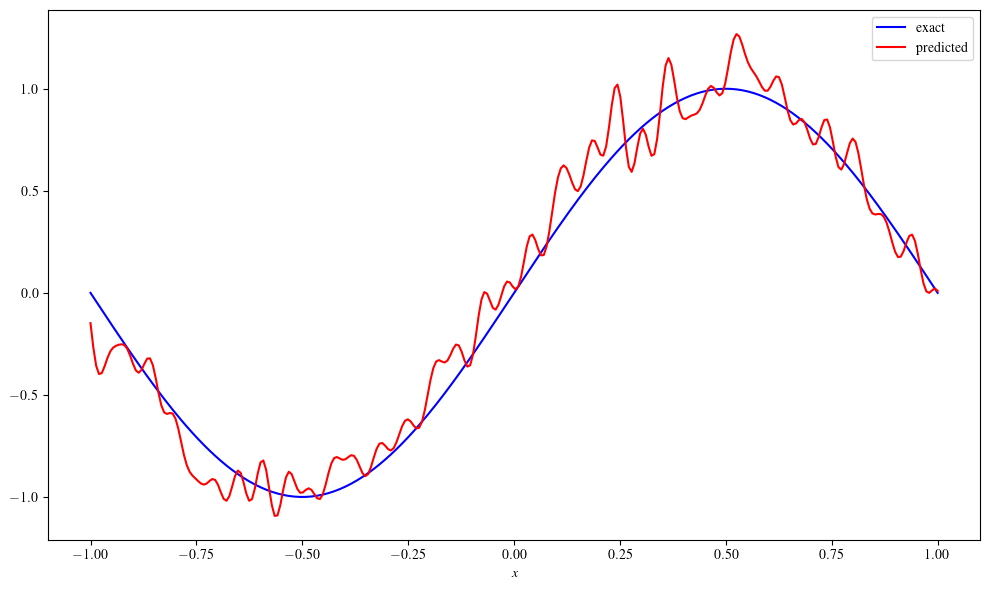

In [26]:
X = torch.linspace(-1, 1, 300, dtype=torch.float64).reshape(-1, 1)
Y_exact = func(X)
model.eval()
with torch.no_grad():
    Y_model = model(X)
plt.figure(figsize=(10, 6))
plt.plot(X, Y_exact, label="exact", color="blue")
plt.plot(X, Y_model, label="predicted", color="red")
plt.xlabel("$x$")
plt.legend()
plt.tight_layout()
plt.savefig('./figures/sin_train_iqpe.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [27]:
n_layers = 1
var = AltRotCXLayer(wires=num_qubits, n_layers=n_layers)

obs = [qml.Identity(0)] + [qml.PauliZ(j) for j in range(num_qubits)]
model = HamiltonianLayer(embed, var, observables=obs)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([1.0])
print(drawer(x))
nump = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", nump)

0: ──H──RZ(1.00)───Rot(3.10,2.80,1.51)─╭●──Rot(4.39,5.84,0.24)─────────────────────────┤ ╭<𝓗>
1: ──H──RZ(3.00)───Rot(2.51,4.18,3.85)─╰X──Rot(2.59,1.14,4.60)─╭●──Rot(0.27,5.33,1.57)─┤ ├<𝓗>
2: ──H──RZ(9.00)───Rot(6.20,5.27,2.43)─╭●──Rot(0.91,3.29,5.22)─╰X──Rot(5.03,4.56,2.89)─┤ ├<𝓗>
3: ──H──RZ(27.00)──Rot(1.37,0.87,3.17)─╰X──Rot(1.08,0.31,5.08)─╭●──Rot(2.46,4.01,1.33)─┤ ├<𝓗>
4: ──H──RZ(81.00)──Rot(4.20,3.29,4.76)─────────────────────────╰X──Rot(4.46,1.46,0.75)─┤ ╰<𝓗>
Number of parameters:  45


In [28]:
optimizer = Adam(model.parameters(), lr=lr, amsgrad=True)
trainer = SupervisedTrainer(
    optimizer=optimizer,
    loss_fn=loss_fn,
    metrics={"MARE": metric},
    num_epochs=num_epochs,
    logger=logger,
)

In [29]:
trainer.train(model, train_data=loader_train, valid_data=loader_valid)

INFO:train_function:Train - Epoch: 1, Loss: 0.469254, Metrics: MARE: 1.085714
INFO:train_function:Validate - Epoch: 1, Loss: 0.453026, Metrics: MARE: 15180.898438
INFO:train_function:Train - Epoch: 2, Loss: 0.145592, Metrics: MARE: 0.894738
INFO:train_function:Validate - Epoch: 2, Loss: 0.142726, Metrics: MARE: 35537.011719
INFO:train_function:Train - Epoch: 3, Loss: 0.126057, Metrics: MARE: 1.202938
INFO:train_function:Validate - Epoch: 3, Loss: 0.124380, Metrics: MARE: 47219.851562
INFO:train_function:Train - Epoch: 4, Loss: 0.023041, Metrics: MARE: 0.412466
INFO:train_function:Validate - Epoch: 4, Loss: 0.019050, Metrics: MARE: 28918.619141
INFO:train_function:Train - Epoch: 5, Loss: 0.037128, Metrics: MARE: 0.601563
INFO:train_function:Validate - Epoch: 5, Loss: 0.034004, Metrics: MARE: 28533.453125
INFO:train_function:Train - Epoch: 6, Loss: 0.030036, Metrics: MARE: 0.601463
INFO:train_function:Validate - Epoch: 6, Loss: 0.028140, Metrics: MARE: 32629.931641
INFO:train_function:Tr

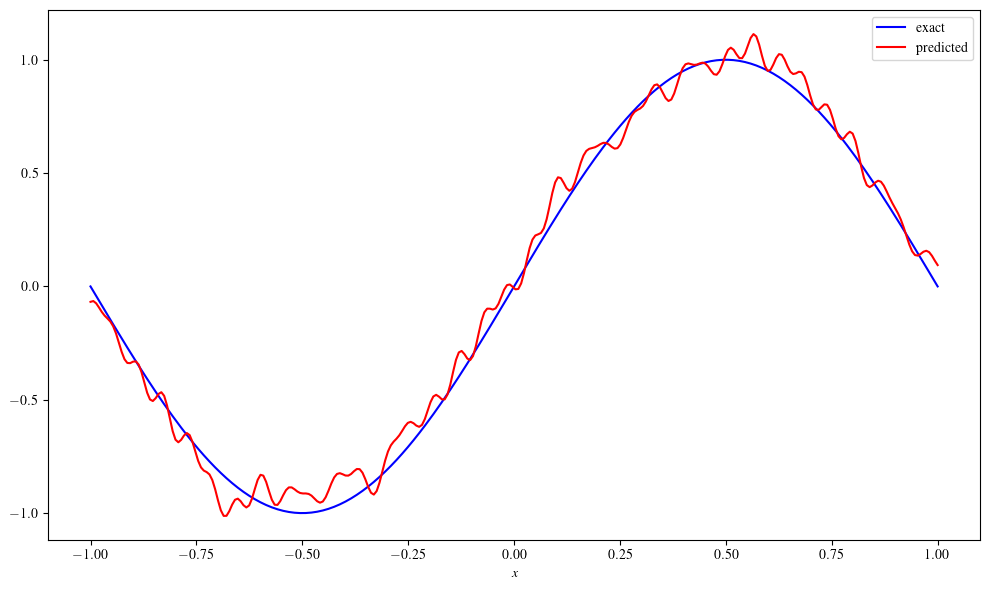

In [30]:
X = torch.linspace(-1, 1, 300, dtype=torch.float64).reshape(-1, 1)
Y_exact = func(X)
model.eval()
with torch.no_grad():
    Y_model = model(X)
plt.figure(figsize=(10, 6))
plt.plot(X, Y_exact, label="exact", color="blue")
plt.plot(X, Y_model, label="predicted", color="red")
plt.xlabel("$x$")
plt.legend()
plt.tight_layout()
plt.savefig('./figures/sin_train_iqpe_l0.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [31]:
num_qubits = 5
def construct_matrix(c):
    size = 2**num_qubits
    H = np.zeros((size, size), dtype=complex)
    np.fill_diagonal(H[:2], 1)
    np.fill_diagonal(H[-2:], -1)

    counter = 0
    for i in range(size):
        for j in range(i+1, size):
            H[i, j] = complex(0, c[counter])
            counter += 1

    H = H + H.conj().T - np.diag(H.diagonal())
    return H

def objective_function(c):
    H = construct_matrix(c)
    size = H.shape[0]
    half = int(size/2)
    eigenvalues = np.linalg.eigvalsh(H)
    eigenvalues_sorted = np.sort(eigenvalues)[::-1]
    target_eigenvalues = [1]*half+[-1]*half
    
    error = np.sum((eigenvalues_sorted - target_eigenvalues)**2)
    return error

num_params = (2**num_qubits * (2**num_qubits - 1)) // 2
initial_guesses = np.ones(num_params)
result = sp.optimize.minimize(objective_function, initial_guesses, method='BFGS')

optimized_c = result.x
print("Cost value:", result.fun)

H = construct_matrix(optimized_c)
eigs, U = np.linalg.eigh(H)
print(eigs)

Cost value: 1.0557280902123383
[-1.00000425 -1.00000176 -1.00000105 -1.00000063 -1.00000044 -1.00000013
 -0.99999987 -0.99999966 -0.99999941 -0.99999901 -0.9999989  -0.99999868
 -0.99999836 -0.99999774 -0.61803559 -0.61803239  0.99999774  0.99999836
  0.99999868  0.9999989   0.99999901  0.99999941  0.99999966  0.99999987
  1.00000013  1.00000044  1.00000063  1.00000105  1.00000176  1.00000425
  1.61803294  1.61803504]


In [32]:
a = -1.0
b = 1.0
num_nodes = 2**num_qubits
hat_basis = HatBasis(a=a, b=b, num_nodes=num_nodes)      
embed = HatBasisQFE(wires=num_qubits, basis=hat_basis, sqrt=True, normalize=False)
var = EmbedU(num_qubits, U.conj().T)

obs = [qml.PauliZ(0)]
model = HamiltonianLayer(embed, var, observables=obs)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([-0.1429])
y = model(x)
print(y)
print(drawer(x))
nump = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", nump)

tensor([2.9976e-14], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
0: ──────────────────────╭U(M2)─╭U(M3)─┤  <𝓗(0.43)>
1: ───────────────╭U(M1)─╰U(M2)─├U(M3)─┤           
2: ────────╭U(M1)─╰U(M1)────────├U(M3)─┤           
3: ─╭U(M0)─╰U(M1)───────────────├U(M3)─┤           
4: ─╰U(M0)──────────────────────╰U(M3)─┤           
Number of parameters:  1


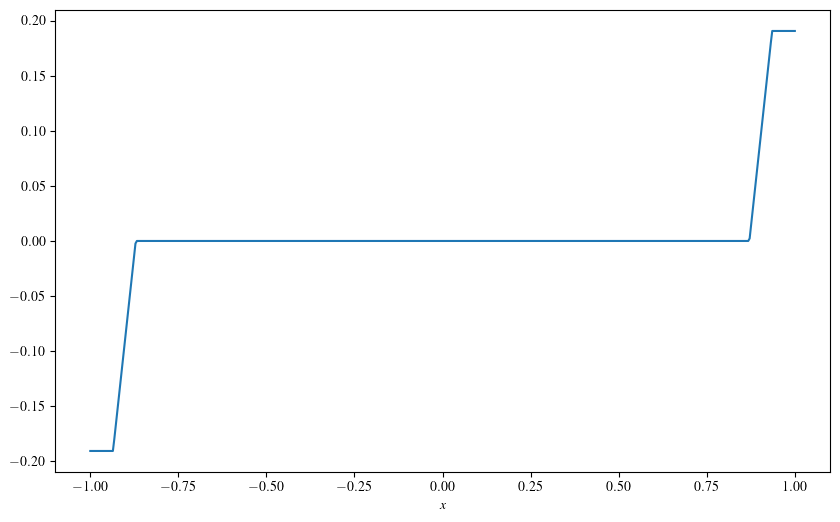

In [33]:
with torch.no_grad():
    yvals = model(xvals)
plt.figure(figsize=(10, 6))
plt.plot(xvals, yvals)
plt.xlabel('$x$')
plt.show()

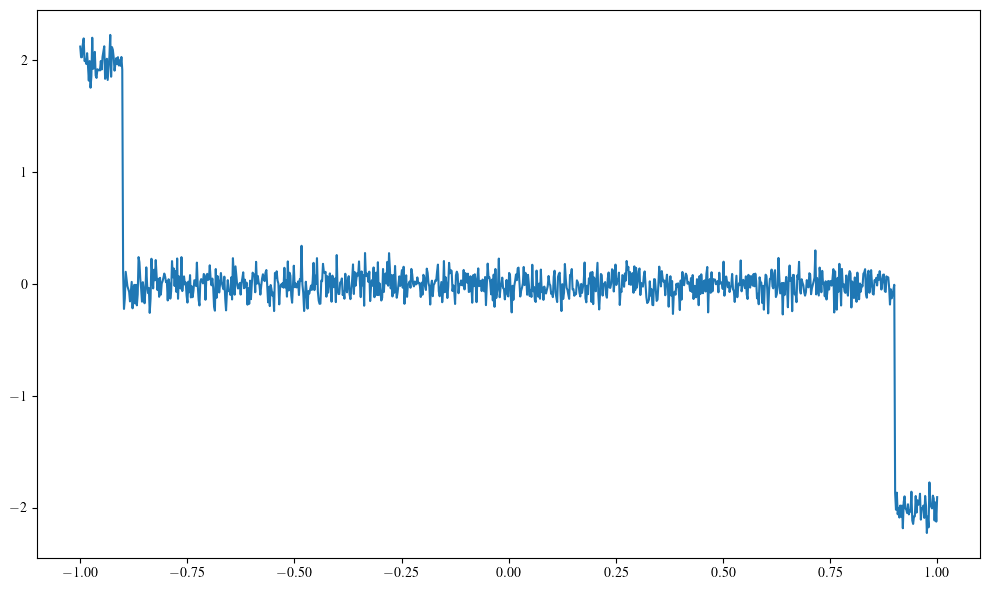

In [34]:
def step_function(
    X, threshold1=-0.9, threshold2=0.9, low_value=2.0, mid_value=0, high_value=-2.0
):
    condition1 = X < threshold1
    condition2 = (X >= threshold1) & (X < threshold2)
    condition3 = X >= threshold2

    values = torch.zeros_like(X)
    values[condition1] = low_value
    values[condition2] = mid_value
    values[condition3] = high_value

    return values

X = torch.linspace(-1, 1, 1000).reshape(-1, 1)
func = step_function
sigma = 0.1
Y = add_gaussian_noise(func(X), std=sigma)
plt.figure(figsize=(10, 6))
plt.plot(X, Y)
plt.tight_layout()
plt.savefig('./figures/segments.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [35]:
N_train = 50
N_valid = 10
batch_size = 10
X_train = torch.linspace(-1, 1, N_train, dtype=torch.float64).reshape(-1, 1)
Y_train = add_gaussian_noise(func(X_train), std=sigma)
X_valid = torch.linspace(-1, 1, N_valid, dtype=torch.float64).reshape(-1, 1)
Y_valid = func(X_valid)
data_train = TensorDataset(X_train, Y_train)
data_valid = TensorDataset(X_valid, Y_valid)
loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
loader_valid = DataLoader(data_valid, batch_size=batch_size, shuffle=True)

lr = 0.1
optimizer = Adam(model.parameters(), lr=lr, amsgrad=True)

num_epochs = 100
trainer = SupervisedTrainer(
    optimizer=optimizer,
    loss_fn=loss_fn,
    metrics={"MARE": metric},
    num_epochs=num_epochs,
    logger=logger,
)

In [36]:
trainer.train(model, train_data=loader_train, valid_data=loader_valid)

INFO:train_function:Train - Epoch: 1, Loss: 0.474357, Metrics: MARE: 0.993212
INFO:train_function:Validate - Epoch: 1, Loss: 0.776897, Metrics: MARE: 0.197091
INFO:train_function:Train - Epoch: 2, Loss: 0.395815, Metrics: MARE: 0.976206
INFO:train_function:Validate - Epoch: 2, Loss: 0.633998, Metrics: MARE: 0.178045
INFO:train_function:Train - Epoch: 3, Loss: 0.331123, Metrics: MARE: 0.988928
INFO:train_function:Validate - Epoch: 3, Loss: 0.517197, Metrics: MARE: 0.160810
INFO:train_function:Train - Epoch: 4, Loss: 0.273747, Metrics: MARE: 1.001362
INFO:train_function:Validate - Epoch: 4, Loss: 0.414515, Metrics: MARE: 0.143965
INFO:train_function:Train - Epoch: 5, Loss: 0.224196, Metrics: MARE: 1.013278
INFO:train_function:Validate - Epoch: 5, Loss: 0.326766, Metrics: MARE: 0.127822
INFO:train_function:Train - Epoch: 6, Loss: 0.182764, Metrics: MARE: 1.027969
INFO:train_function:Validate - Epoch: 6, Loss: 0.254303, Metrics: MARE: 0.112762
INFO:train_function:Train - Epoch: 7, Loss: 0.

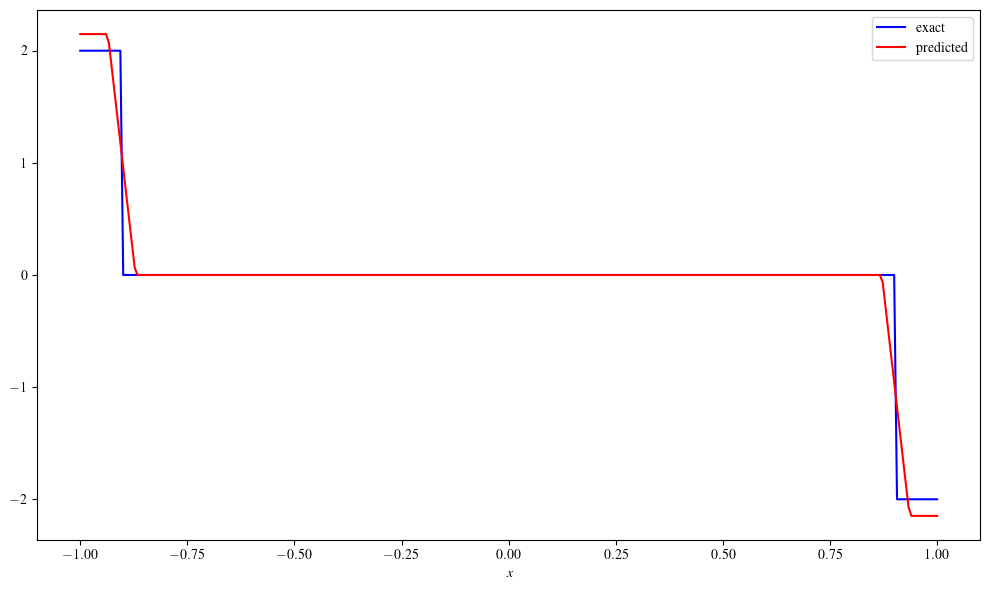

In [37]:
X = torch.linspace(-1, 1, 300, dtype=torch.float64).reshape(-1, 1)
Y_exact = func(X)
model.eval()
with torch.no_grad():
    Y_model = model(X)
plt.figure(figsize=(10, 6))
plt.plot(X, Y_exact, label="exact", color="blue")
plt.plot(X, Y_model, label="predicted", color="red")
plt.xlabel("$x$")
plt.legend()
plt.tight_layout()
plt.savefig('./figures/twosteps_train_pptnqfe.pdf', format='pdf', bbox_inches='tight')
plt.show()